## Discarding outliers

### Objective

Try to analyze the movement at bike stations discarding the atypical moviment, e.g., bike relocation.

Please run first the *Outlier hunting* section at [notebook 06](06-more-data-exploration.ipynb) to remove history outliers with respect to instant `free_bikes` increase.

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from ipywidgets import interact
from bokeh.plotting import figure, output_notebook, show
from bokeh.resources import INLINE

output_notebook(resources=INLINE)

from bikescience.usage_metric import compute_usage_variation, calculate_usage_metric
import bikescience.filter_select as select
import bikescience.input_data as input
from bikescience.neighborhood import determine_neighborhood_indicators

Loading BokehJS ...

### History

In [2]:
history = pd.read_csv('data/output/clean_history.csv', parse_dates=['timestamp'])
history['per_hour'] = history['timestamp'].dt.to_period('h').dt.to_timestamp()
history.head(5)

id                 name  \
0  acb732cd5739a3bf5962c3fe35f41e1f  1 - Largo da Batata   
1  acb732cd5739a3bf5962c3fe35f41e1f  1 - Largo da Batata   
2  acb732cd5739a3bf5962c3fe35f41e1f  1 - Largo da Batata   
3  acb732cd5739a3bf5962c3fe35f41e1f  1 - Largo da Batata   
4  acb732cd5739a3bf5962c3fe35f41e1f  1 - Largo da Batata   

                timestamp  free_bikes  empty_slots  total_slots  \
0 2018-05-26 18:03:55.139          35           20           55   
1 2018-05-26 18:09:52.481          35           20           55   
2 2018-05-26 18:14:49.286          36           19           55   
3 2018-05-26 18:21:06.639          34           21           55   
4 2018-05-26 18:27:43.035          37           18           55   

             per_hour  
0 2018-05-26 18:00:00  
1 2018-05-26 18:00:00  
2 2018-05-26 18:00:00  
3 2018-05-26 18:00:00  
4 2018-05-26 18:00:00

Per-hour usage:

In [3]:
usage_variation = compute_usage_variation(history, 'per_hour')
usage_variation['hour_of_day'] = usage_variation['per_hour'].dt.hour
usage_variation['day_of_week'] = usage_variation['per_hour'].dt.dayofweek
usage_variation['per_day'] = usage_variation['per_hour'].dt.to_period('d').dt.to_timestamp()
usage_variation.head(5)

id                           name  \
0  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
1  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
2  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
3  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   
4  003c832d084651a62af515b0a330eb55  239 - Avenida Antônio Batuira   

             per_hour  free_bikes_increase  free_bikes_decrease  hour_of_day  \
0 2018-05-26 17:00:00                    0                    0           17   
1 2018-05-26 18:00:00                    0                    3           18   
2 2018-05-26 19:00:00                    1                    1           19   
3 2018-05-26 20:00:00                    0                    1           20   
4 2018-05-26 21:00:00                    0                    0           21   

   day_of_week    per_day  
0            5 2018-05-26  
1            5 2018-05-26  
2            5 2018-05-26  
3            5 2018-05-26  
4            5 2018-05-26

Mean usage:

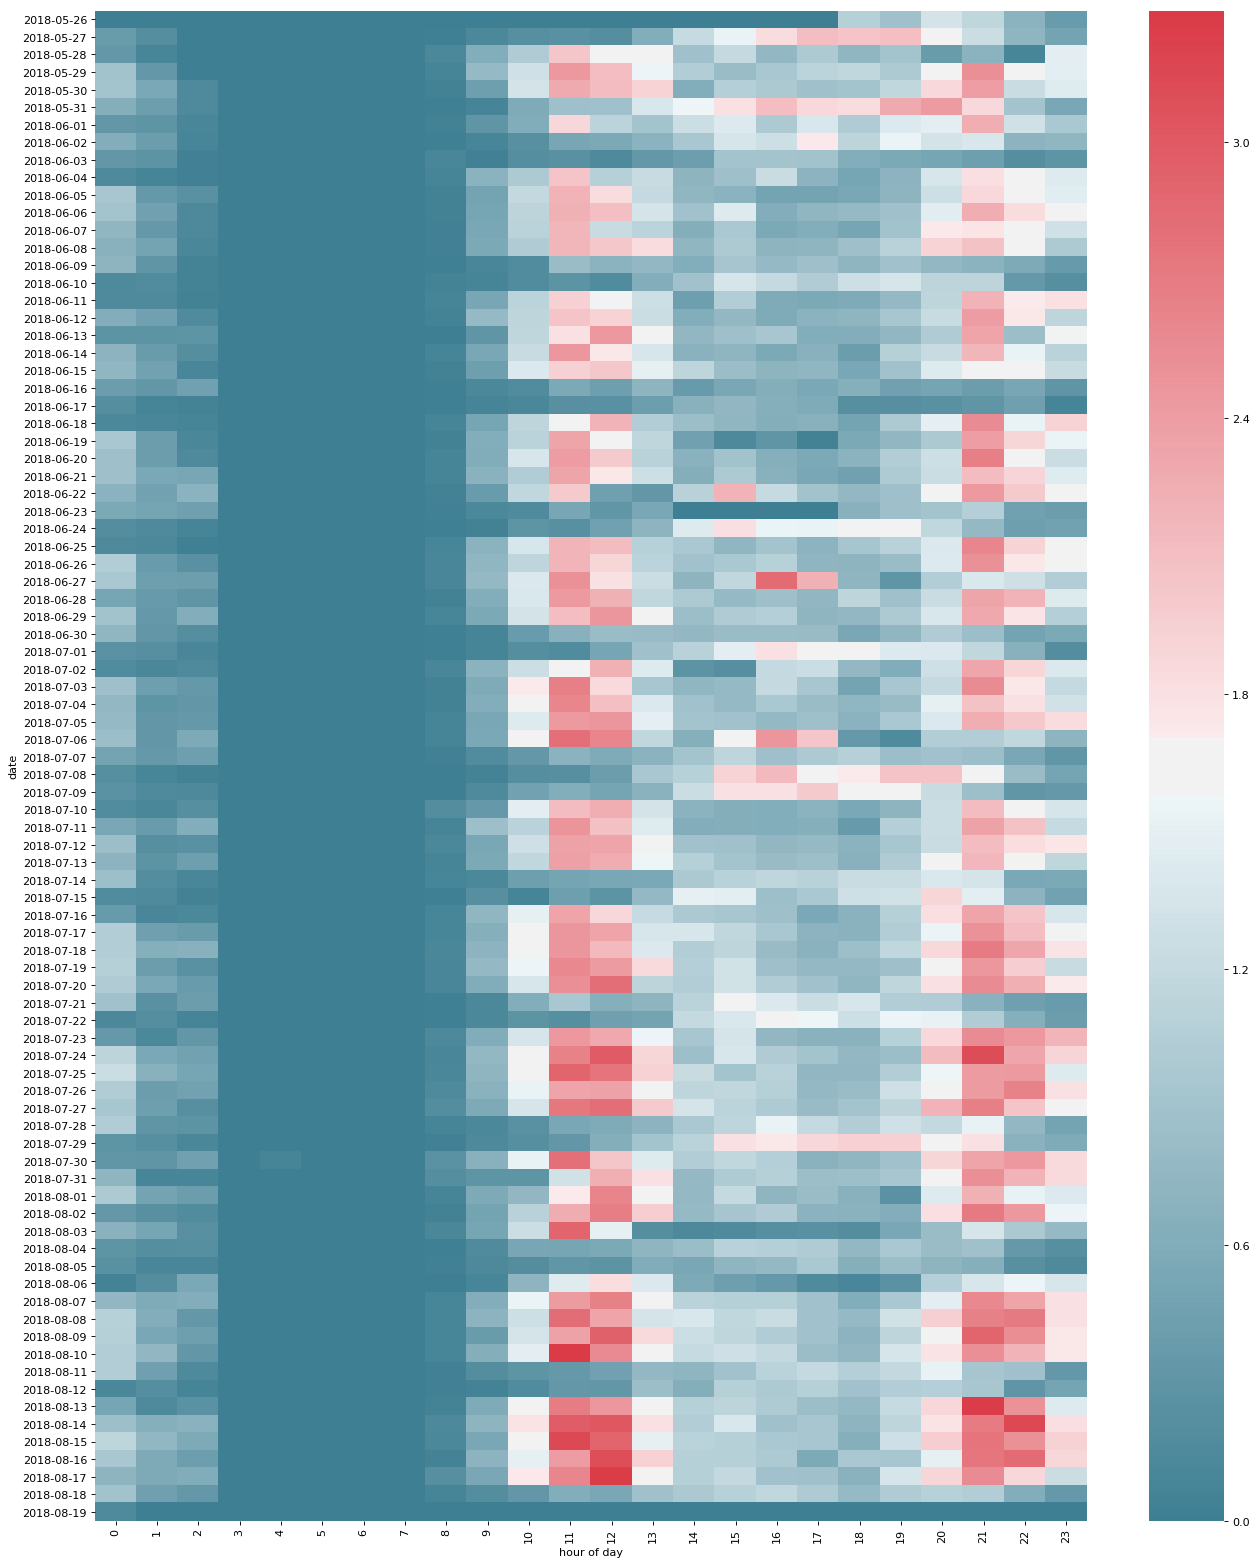

In [4]:
def plot_heatmap(df, height=25):
    agg = df.groupby(['hour_of_day', 'per_day']).agg({'free_bikes_increase': 'mean'}).unstack(level=0, fill_value=0)
    fig = plt.figure(figsize=(20, height), dpi=80, facecolor='w', edgecolor='k')
    sub = sns.heatmap(agg, cmap=sns.diverging_palette(220, 10, as_cmap=True))
    sub.set(xlabel='hour of day', ylabel='date', xticklabels=agg.columns.levels[1], yticklabels=agg.index.to_period('d'))
    plt.show()

plot_heatmap(usage_variation)

Separating weekend/holidays and work days:

In [5]:
weekend_and_holidays = select.filter_weekend_and_holidays(usage_variation, include=True)
work_days = select.filter_weekend_and_holidays(usage_variation, include=False)

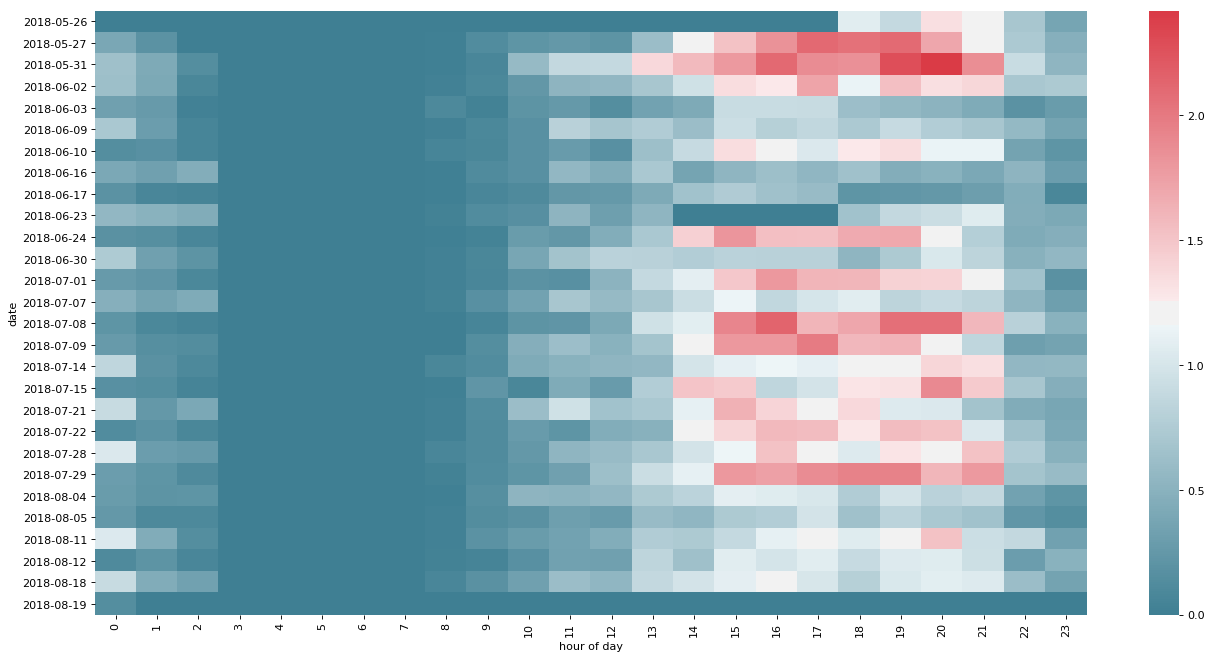

In [6]:
plot_heatmap(weekend_and_holidays, height=10)

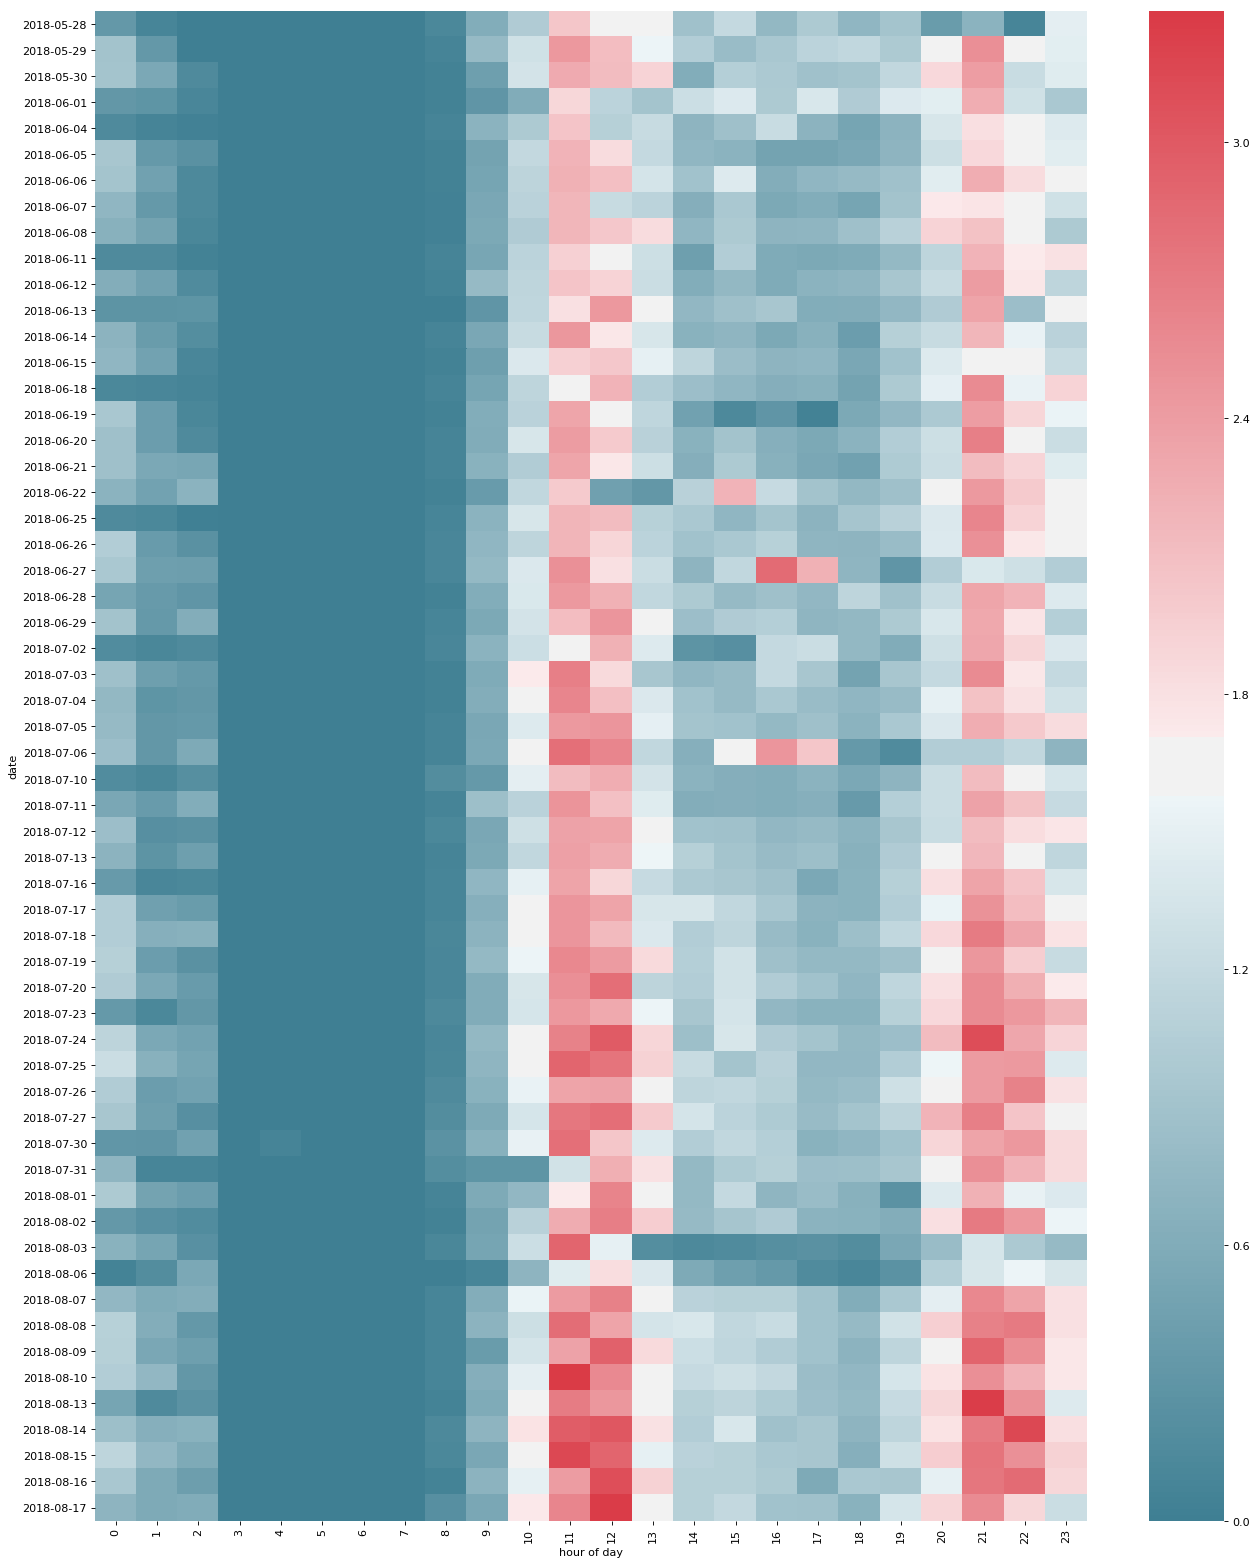

In [7]:
plot_heatmap(work_days)

### Usage metrics

In [8]:
station_usage = calculate_usage_metric(usage_variation)
station_usage.sort_values('general_daily_increase', ascending=False, inplace=True)
station_usage.head(5)

id                                 name  \
79  acb732cd5739a3bf5962c3fe35f41e1f                  1 - Largo da Batata   
94  d11f2a14cef28e32ae3ace3a90069534        27 - Rua Min. Jesuíno Cardoso   
55  75a2f4d8030c58515bf5754399a99e5e  17 - Rua José Gonçalves de Oliveira   
52  6f0ce1a3e4a933999494f860ab32ee62               23 - CPTM Vila Olímpia   
91  ca0efc8075b809b6044394a9e6fcb468                         121 - Insper   

    general_daily_increase  weekend_and_holidays_daily_increase  \
79              203.176471                            85.888889   
94               85.162791                            28.750000   
55               68.847059                            17.851852   
52               55.647059                            21.111111   
91               50.220930                            41.821429   

    work_days_daily_increase  
79                257.775862  
94                112.396552  
55                 92.586207  
52                 71.724138  
91                 54.275862

Data for analysis:

In [11]:
geographical = input.load_stations_hexagons()
accessibility = input.load_accessibility(geographical)
socioeconomical = input.load_socioeconomic()
neighborhood = pd.read_csv('data/output/neighborhood_indicators.csv')

stations_merge = station_usage \
        .merge(geographical, left_on='id', right_on='station_id') \
        .merge(neighborhood, on='hex_id') \
        .merge(accessibility, left_on='id', right_on='station_id', how='left') \
        .fillna(0)
metrics = ['general_daily_increase', 'weekend_and_holidays_daily_increase', 'work_days_daily_increase']

indicators = ['neighbors_L5_' + col for col in socioeconomical.columns]
indicators.extend(['in_accessibility', 'out_accessibility'])

In [12]:
indicators

['neighbors_L5_total_loading',
 'neighbors_L5_total_unloading',
 'neighbors_L5_stops_len',
 'neighbors_L5_trips_len',
 'neighbors_L5_job_qty',
 'neighbors_L5_population',
 'neighbors_L5_education_qty',
 'neighbors_L5_health_qty',
 'neighbors_L5_0_2_salaries',
 'neighbors_L5_2_3_salaries',
 'neighbors_L5_3_5_salaries',
 'neighbors_L5_5_10_salaries',
 'neighbors_L5_above_10_salaries',
 'in_accessibility',
 'out_accessibility']

Correlations:

In [13]:
colors = ['firebrick', 'orange', 'steelblue']
tools = 'box_zoom,pan,reset,save'
regression = LinearRegression()

def coefficients(df, col1, col2):
    print('    Pearson coefficient:', np.corrcoef(df[col1], df[col2])[0][1])
    spearman = stats.spearmanr(df[col1], df[col2])
    print('    Spearman coefficient:', spearman.correlation, '/ pvalue =', spearman.pvalue)
    X_train, X_test, y_train, y_test = train_test_split(df[[col1]], df[col2], test_size=0.33)
    regression.fit(X_train, y_train)
    y_pred = regression.predict(X_test)
    print('    R2 score:', r2_score(y_test, y_pred))
    return X_test[col1], y_pred

@interact(col=indicators, selected_metric=metrics)
def plot_indicators(col, selected_metric):
    print(col, 'vs.', selected_metric)
    p = figure(plot_width=800, plot_height=600, tools=tools)
    p.xaxis.axis_label = col
    p.yaxis.axis_label = selected_metric
    p.circle(stations_merge[col], stations_merge[selected_metric], color='red')
    linear = coefficients(stations_merge, col, selected_metric)
    p.line(linear[0], linear[1], line_color= 'navy')
    show(p)

interactive(children=(Dropdown(description='col', options=('neighbors_L5_total_loading', 'neighbors_L5_total_unloading', 'neighbors_L5_stops_len', 'neighbors_L5_trips_len', 'neighbors_L5_job_qty', 'neighbors_L5_population', 'neighbors_L5_education_qty', 'neighbors_L5_health_qty', 'neighbors_L5_0_2_salaries', 'neighbors_L5_2_3_salaries', 'neighbors_L5_3_5_salaries', 'neighbors_L5_5_10_salaries', 'neighbors_L5_above_10_salaries', 'in_accessibility', 'out_accessibility'), value='neighbors_L5_total_loading'), Dropdown(description='selected_metric', options=('general_daily_increase', 'weekend_and_holidays_daily_increase', 'work_days_daily_increase'), value='general_daily_increase'), Output()), _dom_classes=('widget-interact',))

Weather analysis:

In [14]:
weather = input.load_per_hour_weather()
weather_columns = ['instant_temperature', 'instant_humidity', 'instant_dew', 'atm_pressure',
       'wind_velocity', ' wind_gust', 'radiation', 'precipitation']

@interact(days=['all days', 'weekends and holidays', 'work days'], col=weather_columns)
def plot_weather(days, col):
    if days == 'all days':
        dataset = usage_variation
    elif days == 'weekends and holidays':
        dataset = weekend_and_holidays
    else:
        dataset = work_days
    merge = dataset.merge(weather, on='per_hour') \
            .groupby([col], as_index=False).agg({'free_bikes_increase': 'mean'})
    p = figure(plot_width=800, plot_height=600, tools=tools)
    p.xaxis.axis_label = col
    p.yaxis.axis_label = 'free_bikes_increase'
    p.circle(merge[col], merge['free_bikes_increase'], color='red', alpha=0.7)
    linear = coefficients(merge, col, 'free_bikes_increase')
    p.line(linear[0], linear[1], line_color='navy')
    show(p)

interactive(children=(Dropdown(description='days', options=('all days', 'weekends and holidays', 'work days'), value='all days'), Dropdown(description='col', options=('instant_temperature', 'instant_humidity', 'instant_dew', 'atm_pressure', 'wind_velocity', ' wind_gust', 'radiation', 'precipitation'), value='instant_temperature'), Output()), _dom_classes=('widget-interact',))